# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import time
from scipy.io import loadmat
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)


![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)
tf.config.experimental.set_virtual_device_configuration(
  gpus[0],
  [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
)

In [3]:
class TaskTime:
    def __init__(self, task_name, show_start=False):
        self.show_start = show_start
        self.task_name = task_name
        self.start_time = time.time()

    def elapsed_time(self):
        return time.time()-self.start_time

    def __enter__(self):
        if self.show_start:
            logging.info('start {}'.format(self.task_name))
        return self;

    def __exit__(self, exc_type, exc_value, exc_tb):
        time.sleep(0.5)
        logging.info('finish {} [elapsed time: {:.2f} seconds]'.format(self.task_name, self.elapsed_time()))


In [4]:
# Run this cell to load the dataset

# train = loadmat('data/train_32x32.mat')
# test = loadmat('data/test_32x32.mat')


train = loadmat('../../10-base/data/svhn/format2/train_32x32.mat')
test = loadmat('../../10-base/data/svhn/format2/test_32x32.mat')


Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [5]:
# Extract the training and testing images and labels separately from the train and test dictionaries loaded for you

def extract_data_label(mat_data):

    X = mat_data['X'].swapaxes(0, 3).swapaxes(2, 3).swapaxes(1, 2)
    y = mat_data['y']
    return X, y

train_data, train_label = extract_data_label(train)
test_data, test_label  = extract_data_label(test)

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
# print(train_data[0, 0, 0])

(73257, 32, 32, 3) (73257, 1)
(26032, 32, 32, 3) (26032, 1)


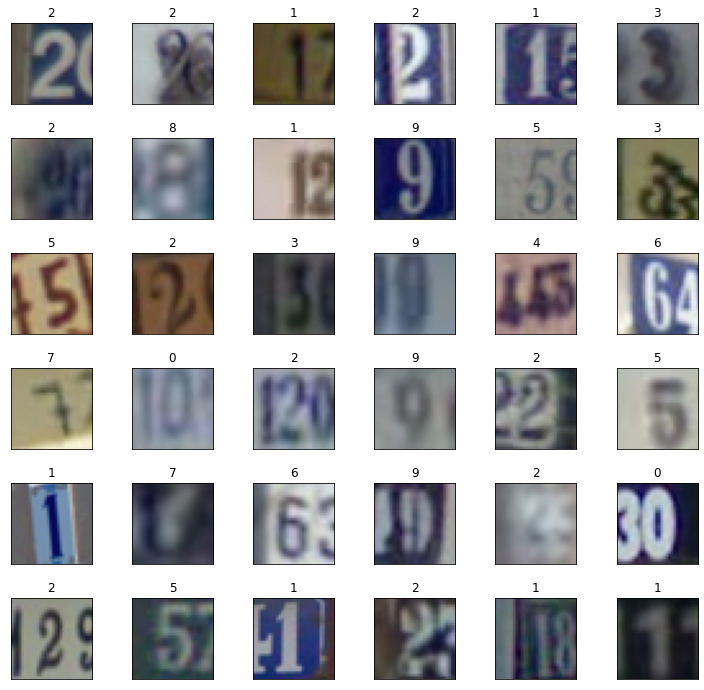

In [6]:
# Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.

plt.figure(figsize=(10,10))
random.seed(228)

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.tight_layout()
    index = random.randint(0, len(train_data))
    plt.imshow(train_data[index])
    label = train_label[index,0] if train_label[index,0]!=10 else 0
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
plt.show()
    

In [7]:
# Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. Hint: retain the channel dimension, which will now have size 1.
    
train_data = np.mean(train_data, axis=3, keepdims=True)/255.0
test_data = np.mean(test_data, axis=3, keepdims=True)/255.0

# print(train_label[50:55])

train_label = np.where(train_label==10, 0, train_label)
test_label = np.where(test_label==10, 0, test_label)
# train_label = np.squeeze(np.where(train_label==10, 0, train_label))
# test_label = np.squeeze(np.where(test_label==10, 0, test_label))

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
# print(train_data[0, 1, 1])
# print(train_label[50:55])

(73257, 32, 32, 1) (73257, 1)
(26032, 32, 32, 1) (26032, 1)


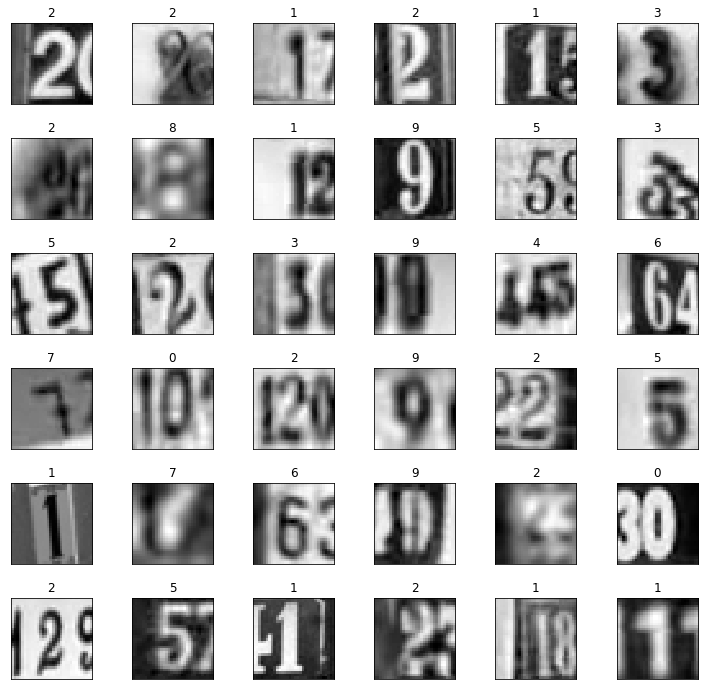

In [8]:
plt.figure(figsize=(10,10))
random.seed(228)

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.tight_layout()
    index = random.randint(0, len(train_data))
    plt.imshow(np.squeeze(train_data[index]), cmap='gray', interpolation='none')
    plt.title(train_label[index, 0])
    plt.xticks([])
    plt.yticks([])
plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [15]:
def get_mlp(input_shape, dropout=0):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(256, activation='relu'))
    if dropout>0: model.add(layers.Dropout(dropout))
    model.add(layers.Dense(256, activation='relu'))
    if dropout>0: model.add(layers.Dropout(dropout))
    model.add(layers.Dense(256, activation='relu'))
    if dropout>0: model.add(layers.Dropout(dropout))
    model.add(layers.Dense(10, activation='softmax'))    
     
    return model


In [16]:
mlp_model = get_mlp(train_data.shape[1:], dropout=0.1)
mlp_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)              

In [17]:
def plot_metrics(history, metrics='accuracy'):
    plt.tight_layout()
    plt.plot(history.history[metrics], label=metrics)
    plt.plot(history.history['val_'+metrics], label = 'val_'+metrics)
    plt.xlabel('epoch')
    plt.ylabel(metrics)
    # plt.ylim([0, 1])
    plt.legend(loc='lower right')

    
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(2,2,1)
    plot_metrics(history, 'accuracy')
    plt.subplot(2,2,2)
    plot_metrics(history, 'loss')        
    plt.show()

def train_evaluate(model, epochs=30, checkpoint_path='./checkpoints_best_only/checkpoint', learning_rate=0.001):
    checkpoint_best_only = ModelCheckpoint(filepath=checkpoint_path,
                                     monitor='val_accuracy',
                                     save_weights_only=True,
                                     save_best_only=True,
                                     verbose=1)  

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)  

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])       

    with TaskTime('training', True):
        history = model.fit(train_data, train_label, epochs=epochs, batch_size=32,
                            validation_data=(test_data, test_label),
                            callbacks = [checkpoint_best_only, early_stopping])
    
    plot_history(history)

2020-11-23 06:23:15,711: INFO: start training


Epoch 1/20
2271/2290 [============================>.] - ETA: 0s - loss: 1.9412 - accuracy: 0.3129
Epoch 00001: val_accuracy improved from -inf to 0.48621, saving model to ./mlp_best_only/checkpoint
2290/2290 [==============================] - 7s 3ms/step - loss: 1.9388 - accuracy: 0.3139 - val_loss: 1.5716 - val_accuracy: 0.4862
Epoch 2/20
2276/2290 [============================>.] - ETA: 0s - loss: 1.3882 - accuracy: 0.5439
Epoch 00002: val_accuracy improved from 0.48621 to 0.59542, saving model to ./mlp_best_only/checkpoint
2290/2290 [==============================] - 7s 3ms/step - loss: 1.3871 - accuracy: 0.5444 - val_loss: 1.2925 - val_accuracy: 0.5954
Epoch 3/20
2274/2290 [============================>.] - ETA: 0s - loss: 1.2084 - accuracy: 0.6123
Epoch 00003: val_accuracy improved from 0.59542 to 0.63729, saving model to ./mlp_best_only/checkpoint
2290/2290 [==============================] - 7s 3ms/step - loss: 1.2083 - accuracy: 0.6123 - val_loss: 1.1760 - val_accuracy: 0.6373
E

2020-11-23 06:25:30,118: INFO: finish training [elapsed time: 134.41 seconds]


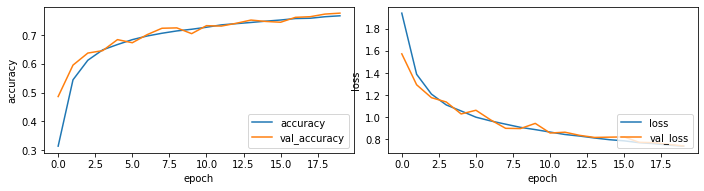

In [18]:
train_evaluate(mlp_model, epochs=20, checkpoint_path='./mlp_best_only/checkpoint', learning_rate=0.0002)

In [19]:
def show_model_performace(model):
    train_loss, train_acc = model.evaluate(train_data,  train_label, verbose=0)
    test_loss, test_acc = model.evaluate(test_data,  test_label, verbose=0)
    print('Train Loss: {:0.3f}, Train Accuracy: {:0.1%}'.format(train_loss, train_acc)) 
    print('Test Loss: {:0.3f}, Test Accuracy: {:0.1%}'.format(test_loss, test_acc)) 
        
show_model_performace(mlp_model)

Train Loss: 0.610, Train Accuracy: 81.2%
Test Loss: 0.740, Test Accuracy: 77.6%


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [96]:
def get_cnn(input_shape, dropout=0, use_bn=False):
    model = models.Sequential()
    model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=input_shape))
    if use_bn: model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    if use_bn: model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    if dropout>0: model.add(layers.Dropout(dropout))
    model.add(layers.Dense(84, activation='relu'))
    if dropout>0: model.add(layers.Dropout(dropout))
    model.add(layers.Dense(10, activation='softmax'))    
    return model

cnn_model = get_cnn(train_data.shape[1:], use_bn=True, dropout=0.3)
cnn_model.summary()

# The parameters of CNN is much less than those of MLP.
#  CNN: 61,794 parameters
#  MLP: 396,554 parameters

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_24 (Batc (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 400)             

2020-11-23 07:58:11,678: INFO: start training


Epoch 1/30
2275/2290 [============================>.] - ETA: 0s - loss: 0.9249 - accuracy: 0.7024
Epoch 00001: val_accuracy improved from -inf to 0.82844, saving model to ./cnn_best_only/checkpoint
2290/2290 [==============================] - 9s 4ms/step - loss: 0.9226 - accuracy: 0.7033 - val_loss: 0.5649 - val_accuracy: 0.8284
Epoch 2/30
2285/2290 [============================>.] - ETA: 0s - loss: 0.5359 - accuracy: 0.8397
Epoch 00002: val_accuracy did not improve from 0.82844
2290/2290 [==============================] - 9s 4ms/step - loss: 0.5361 - accuracy: 0.8397 - val_loss: 0.6712 - val_accuracy: 0.7912
Epoch 3/30
2284/2290 [============================>.] - ETA: 0s - loss: 0.4714 - accuracy: 0.8598
Epoch 00003: val_accuracy improved from 0.82844 to 0.86152, saving model to ./cnn_best_only/checkpoint
2290/2290 [==============================] - 9s 4ms/step - loss: 0.4716 - accuracy: 0.8598 - val_loss: 0.4808 - val_accuracy: 0.8615
Epoch 4/30
2277/2290 [===========================

2020-11-23 08:01:54,140: INFO: finish training [elapsed time: 222.46 seconds]


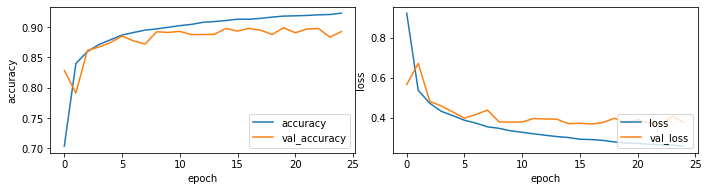

In [97]:
train_evaluate(cnn_model, epochs=10, checkpoint_path='./cnn_best_only/checkpoint', learning_rate=0.001)

In [99]:
# 可以看到，从第9个epoch开始，始终在90%徘徊
show_model_performace(cnn_model)

Train Loss: 0.174, Train Accuracy: 95.0%
Test Loss: 0.376, Test Accuracy: 89.3%


The test accuracy of CNN model has much higher than that of MLP.  
- MLP Model   
    Train Loss: 0.610, Train Accuracy: 81.2%       
    Test Loss: 0.740, Test Accuracy: 77.6%

In [115]:
def get_cnn1(input_shape, dropout=0, use_bn=False):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    if use_bn: model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    if use_bn: model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    if use_bn: model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    if dropout>0: model.add(layers.Dropout(dropout))
    model.add(layers.Dense(10, activation='softmax')) 
    
    return model


# 参考 https://www.kaggle.com/dimitriosroussis/svhn-classification-with-cnn-keras-96-acc
def get_cnn2(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),    
        layers.Dense(10,  activation='softmax')
    ])
    return model

2020-11-23 08:05:39,453: INFO: start training


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
batch_normalization_29 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_30 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 6, 6, 64)        

2020-11-23 08:07:16,590: INFO: finish training [elapsed time: 97.14 seconds]


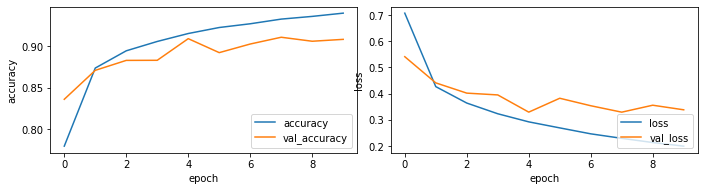

Train Loss: 0.162, Train Accuracy: 95.0%
Test Loss: 0.338, Test Accuracy: 90.8%


In [101]:


cnn_model = get_cnn1(train_data.shape[1:], use_bn=True, dropout=0.3)
cnn_model.summary()

train_evaluate(cnn_model, epochs=10, checkpoint_path='./cnn_best_only/checkpoint', learning_rate=0.001)
show_model_performace(cnn_model)

2020-11-23 08:07:33,551: INFO: start training


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_25 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_83 (Dense)             (None, 64)              

2020-11-23 08:08:59,252: INFO: finish training [elapsed time: 85.70 seconds]


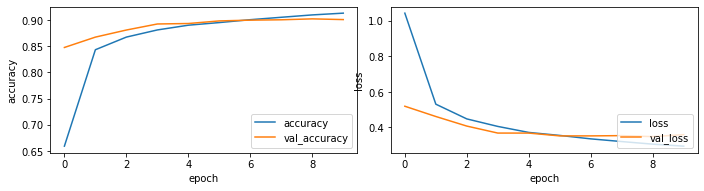

Train Loss: 0.221, Train Accuracy: 93.3%
Test Loss: 0.359, Test Accuracy: 90.0%


In [102]:
cnn_model = get_cnn1(train_data.shape[1:], use_bn=False, dropout=0.3)
cnn_model.summary()

train_evaluate(cnn_model, epochs=10, checkpoint_path='./cnn_best_only/checkpoint', learning_rate=0.001)
show_model_performace(cnn_model)

2020-11-23 08:33:32,783: INFO: start training


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_47 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_48 (Batc (None, 16, 16, 64)      

Epoch 18/50
2290/2290 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9498
Epoch 00018: val_accuracy did not improve from 0.95310
2290/2290 [==============================] - 13s 6ms/step - loss: 0.1707 - accuracy: 0.9498 - val_loss: 0.2480 - val_accuracy: 0.9350
Epoch 19/50
2288/2290 [============================>.] - ETA: 0s - loss: 0.1662 - accuracy: 0.9503
Epoch 00019: val_accuracy did not improve from 0.95310
2290/2290 [==============================] - 13s 6ms/step - loss: 0.1662 - accuracy: 0.9503 - val_loss: 0.2088 - val_accuracy: 0.9512
Epoch 20/50
2287/2290 [============================>.] - ETA: 0s - loss: 0.1610 - accuracy: 0.9531
Epoch 00020: val_accuracy improved from 0.95310 to 0.95321, saving model to ./cnn_best_only/checkpoint
2290/2290 [==============================] - 13s 6ms/step - loss: 0.1610 - accuracy: 0.9531 - val_loss: 0.2035 - val_accuracy: 0.9532
Epoch 21/50
2282/2290 [============================>.] - ETA: 0s - loss: 0.1582 - accura

2020-11-23 08:40:17,062: INFO: finish training [elapsed time: 404.28 seconds]


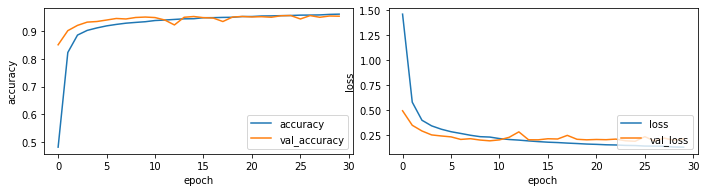

Train Loss: 0.053, Train Accuracy: 98.4%
Test Loss: 0.214, Test Accuracy: 95.4%


In [116]:
cnn_model = get_cnn2(train_data.shape[1:])
cnn_model.summary()

train_evaluate(cnn_model, epochs=50, checkpoint_path='./cnn_best_only/checkpoint', learning_rate=0.0005)
show_model_performace(cnn_model)

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [94]:
print('-'*25, 'cnn best model', '-'*25)
cnn_model = get_cnn(train_data.shape[1:], use_bn=True, dropout=0.3)
cnn_model.load_weights('./cnn_best_only/checkpoint')
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])    
show_model_performace(cnn_model)

print('-'*25, 'mlp best model', '-'*25)
mlp_model = get_mlp(train_data.shape[1:], dropout=0.1)
mlp_model.load_weights('./mlp_best_only/checkpoint')
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 
show_model_performace(mlp_model)

------------------------- cnn best model -------------------------
Train Loss: 0.234, Train Accuracy: 93.1%
Test Loss: 0.381, Test Accuracy: 89.2%
------------------------- mlp best model -------------------------
Train Loss: 0.610, Train Accuracy: 81.2%
Test Loss: 0.740, Test Accuracy: 77.6%


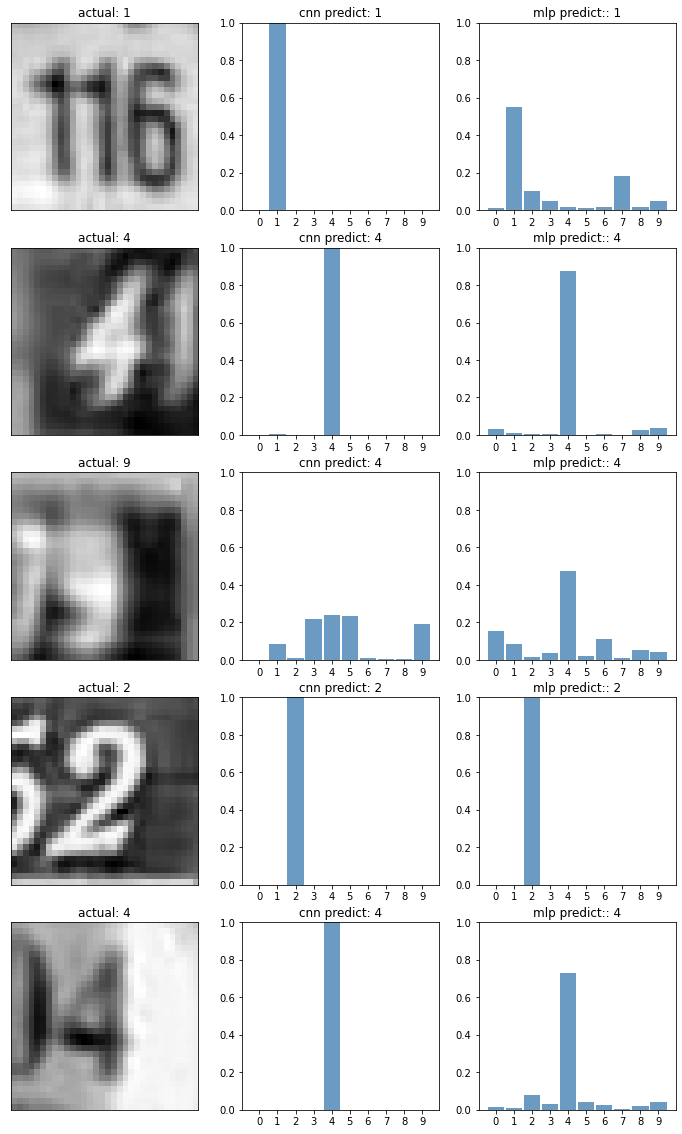

In [95]:
plt.figure(figsize=(12, 20))
random.seed(123)

image_cnt=5
data = test_data
label = test_label
for i in range(image_cnt):
    plt.subplot(image_cnt,3,3*i+1)
    index = random.randint(0, len(data))
    plt.imshow(np.squeeze(data[index]), cmap='gray', interpolation='none')
    plt.title('actual: {}'.format(label[index, 0]))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(image_cnt,3,3*i+2)
    cnn_predict = np.squeeze(cnn_model.predict(data[index:index+1]))
    cnn_max_lik_predict = np.argmax(cnn_predict)
    plt.bar(range(10), cnn_predict, width=0.9, color='steelblue', alpha=0.8) 
    plt.ylim(0,1)
    plt.xticks(range(0,10))
    plt.title('cnn predict: {}'.format(cnn_max_lik_predict))
    
    plt.subplot(image_cnt,3,3*i+3)
    mlp_predict = np.squeeze(mlp_model.predict(data[index:index+1]))
    mlp_max_lik_predict = np.argmax(mlp_predict)
    plt.bar(range(10), mlp_predict, width=0.9, color='steelblue', alpha=0.8)   
    plt.ylim(0,1)
    plt.xticks(range(0,10))
    plt.title('mlp predict:: {}'.format(mlp_max_lik_predict))

plt.show()

可以看到cnn模型的确比mlp好很多啊。